In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from itertools import combinations
import json
import warnings

In [5]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [6]:
#Add functions for Univariate analysis
def describe_numerical_col(df, col_name):
    info = df[[col_name]].describe().to_dict()[col_name]
    info['shapiro'] = f'{stats.shapiro(df[col_name])[1]: .5f}'
    info['normal'] = float(info['shapiro']) > 0.05
    info['missing'] = df[col_name].isna().sum()
    info['skew'] = f'{stats.skew(df[col_name]):.5f}'
    info['type'] = ('slight ' if info['normal'] else '') +\
        ('right(positive)' if float(info['skew']) > 0 else 'left(negative)') + '-skew'

    fig, ax = plt.subplots(2, 2, figsize=(16, 7), gridspec_kw={'height_ratios':(.85, .15)})
    sns.histplot(df[col_name], kde=True, ax=ax[0, 0], color='#55A868')
    sns.boxplot(df[col_name], orient='h', ax=ax[1, 0], color="#5583A8")
    counts, bin_edges = np.histogram(df[col_name], bins=10, density = True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    ax[1, 1] = plt.subplot(122)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.legend()
    ax[0, 0].set_xticklabels([])
    ax[1, 0].set_yticklabels([])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('Count')
    fig.suptitle(col_name, fontsize=30)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(info_df)
    print('='*40)
    
def categorize_numerical_col(col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)

def describe_categorical_col(df, col_name):
    counts = pd.DataFrame(df[col_name].value_counts()).reset_index()
    counts.columns = ['Group', 'Count']
    total = sum(counts['Count'])
    counts['%'] = (counts['Count'] / total * 100).round(2)

    fig = px.pie(
        counts,
        names='Group',
        values='Count',
        title=f'<b>Distribution of {col_name} in each group</b>',
        color='Group',
        hole=0.3
    )

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',

    )

    fig.update_layout(
        title_x=0.5,
        legend_title_text='Groups',
        font=dict(family="Arial, sans-serif", size=14)
    )
    fig.show()
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(counts)
    print('='*40)
    # plt.figure(figsize=(12, 7))
    # ax = sns.barplot(
    #     data=counts,
    #     x=counts[col_name],
    #     y=counts['count'],
    #     palette='viridis'
    # )

    # for i in range(len(ax.patches)):
    #     p = ax.patches[i]
    #     percentage = counts['percents'][i]
    #     ax.annotate(f'{percentage:.2f}%',
    #                 (p.get_x() + p.get_width()/2., p.get_height()),
    #                 ha='center', va='center',
    #                 fontsize=11, color='black',
    #                 xytext=(0, 10),
    #                 textcoords='offset points')
    
    # plt.ylim(0, max(counts['count']) * 1.15)
    # ax.set_xlabel('')
    # ax.set_title(f'Distribution of {col_name} in each group')
    # plt.show()

def describe_num_num_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر عددی"""
    # آزمون نرمال بودن با شاپیرو
    shapiro1_stat, shapiro1_p = stats.shapiro(df[col1])
    shapiro2_stat, shapiro2_p = stats.shapiro(df[col2])
    
    # تشخیص نرمال بودن (p > 0.05 یعنی نرمال)
    is_normal1 = shapiro1_p > 0.05
    is_normal2 = shapiro2_p > 0.05
    both_normal = is_normal1 & is_normal2
    
    # انتخاب آزمون مناسب
    if both_normal:
        # استفاده از پیرسون
        corr_stat, p_value = stats.pearsonr(df[col1], df[col2])
        test_used = 'Pearson'
        correlation = corr_stat
    else:
        # استفاده از اسپیرمن
        corr_stat, p_value = stats.spearmanr(df[col1], df[col2])
        test_used = 'Spearman'
        correlation = corr_stat
    
    r2_score = correlation ** 2
    
    info = {
        'shapiro_p_col1': f'{shapiro1_p:.5f}',
        'shapiro_p_col2': f'{shapiro2_p:.5f}',
        'col1_normal': is_normal1,
        'col2_normal': is_normal2,
        'test_used': test_used,
        'correlation': f'{correlation:.5f}',
        'r_squared': f'{r2_score:.5f}',
        'p_value': f'{p_value:.5f}',
        'significant': p_value < 0.05,
        'relationship_strength': 'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.3 else 'weak',
        'relationship_direction': 'positive' if correlation > 0 else 'negative'
    }
    
    # رسم نمودار
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{col1} vs {col2} - {test_used} Correlation', fontsize=14)

    # Scatter Plot
    axes[0].scatter(df[col1], df[col2],
                    s=60, alpha=0.7, color='blue', edgecolors='black', linewidth=0.5)
    axes[0].set_title('Scatter Plot')
    axes[0].set_xlabel(col1)
    axes[0].set_ylabel(col2)
    axes[0].grid(True, alpha=0.3)

    # Hexbin Plot
    axes[1].hexbin(df[col1], df[col2], gridsize=20, cmap='Blues', mincnt=1)
    axes[1].set_title('Hexbin Plot')
    axes[1].set_xlabel(col1)
    axes[1].set_ylabel(col2)
    axes[1].yaxis.set_label_position("right")
    
    plt.tight_layout()
    plt.show()
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*15 + f' {col1} vs {col2} ' + '='*15)
    print(info_df)
    print('='*50)

def describe_cat_num_relationship(df, cat_col, num_col):
    """تحلیل رابطه بین متغیر کیفی و کمی"""
    
    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Box plot
    sns.boxplot(data=df, x=cat_col, y=num_col, ax=axs[0, 0])
    axs[0, 0].set_title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=45)
    
    # Violin plot
    sns.violinplot(data=df, x=cat_col, y=num_col, ax=axs[0, 1])
    axs[0, 1].set_title(f'{num_col} Distribution by {cat_col}')
    plt.xticks(rotation=45)
    
    # Bar plot of means
    means = df.groupby(cat_col)[num_col].mean().sort_values(ascending=False)
    sns.barplot(x=means.index, y=means.values, ax=axs[1, 0])
    axs[1, 0].set_title(f'Mean {num_col} by {cat_col}')
    plt.xticks(rotation=45)
    
    # Count plot of categories
    sns.countplot(data=df, x=cat_col, ax=axs[1, 1])
    axs[1, 1].set_title(f'Count of {cat_col}')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    

def describe_cat_cat_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر کیفی"""
    # جدول تطبیقی
    contingency_table = pd.crosstab(df[col1], df[col2])
    normalized = pd.crosstab(df[col1], df[col2], normalize='index')
    
    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Heatmap of contingency table
    sns.heatmap(contingency_table, annot=True, cbar=False ,fmt='d', cmap=['White'], ax=axs[0, 0], linecolor='lightgray', linewidths=0.7)
    axs[0, 0].set_title(f'Contingency Table: {col1} vs {col2}')
    
    # Stacked bar chart 100%
    normalized.plot.bar(stacked=True, ax=axs[0, 1])
    axs[0, 1].set_title(f'Stacked Bar: {col1} vs {col2}')
    axs[0, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    
    # Normalized heatmap (percentages)
    sns.heatmap(normalized, annot=True, fmt='.2%', cbar=False, cmap=['White'], ax=axs[1, 0], linecolor='lightgray', linewidths=0.7)
    axs[1, 0].set_title(f'Normalized Contingency Table')
    
    # Count plots side by side
    contingency_table.plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title(f'Count Comparison')
    axs[1, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    

def describe_target_relationship(df, feature_col, target_col):
    """تحلیل رابطه هر متغیر با متغیر هدف"""
    if df[feature_col].dtype in ['object', 'category']:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_cat_relationship(df, feature_col, target_col)
        else:
            describe_cat_num_relationship(df, feature_col, target_col)
    else:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_num_relationship(df, target_col, feature_col)
        else:
            describe_num_num_relationship(df, feature_col, target_col)

#non_prarametric

def numeric_nonparm_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.wilcoxon(data - np.median(data))
        result["test"] = "Wilcoxon"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        result["test"] = "Man-Whitney-U"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.kruskal(*groups)
        result["test"] = "Kruskal"

    elif test_type == "variance-test":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.friedmanchisquare(*groups)
        result["test"] = "Friedman"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

#parametric
def numeric_parametric_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.ttest_1samp(data, np.mean(data))
        result["test"] = "Ttest"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
        result["test"] = "Ttest"

    elif test_type == "paired":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_rel(group1, group1)
        result["test"] = "Ttest"

    elif test_type == "non-equal-var":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        result["test"] = "Welch"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.f_oneway(*groups)
        result["test"] = "One-Way ANOVA"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

        if p_value < alpha:
            print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        else:
            print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")


In [7]:
df = pd.read_csv("marketing.csv")

In [8]:
print("اطلاعات اولیه دیتاست:")


print(df.isna().sum())

print(df.nunique())

اطلاعات اولیه دیتاست:
CustomerID               0
Age                      0
Gender                   0
Income                  79
CampaignChannel        154
CampaignType             0
AdSpend                  0
ClickThroughRate         0
ConversionRate           0
WebsiteVisits            0
PagesPerVisit            0
TimeOnSite              79
SocialShares             0
EmailOpens               0
EmailClicks              0
PreviousPurchases        0
LoyaltyPoints            0
AdvertisingPlatform      0
AdvertisingTool          0
Conversion               0
dtype: int64
CustomerID             2010
Age                      52
Gender                    2
Income                 1923
CampaignChannel           6
CampaignType              4
AdSpend                2010
ClickThroughRate       2010
ConversionRate         2010
WebsiteVisits            50
PagesPerVisit          2010
TimeOnSite             1931
SocialShares            100
EmailOpens               20
EmailClicks              23
Previ

In [9]:
# بررسی uniqueness برای CustomerID
if df['CustomerID'].nunique() == len(df):
    print("\nهمه CustomerIDها منحصربه‌فرد هستند.")
else:
    print("\nCustomerIDهای تکراری وجود دارند!")
    print(df[df['CustomerID'].duplicated(keep=False)])


همه CustomerIDها منحصربه‌فرد هستند.


تحلیل تک متغیر و پاکسازی اطلاعات


Age


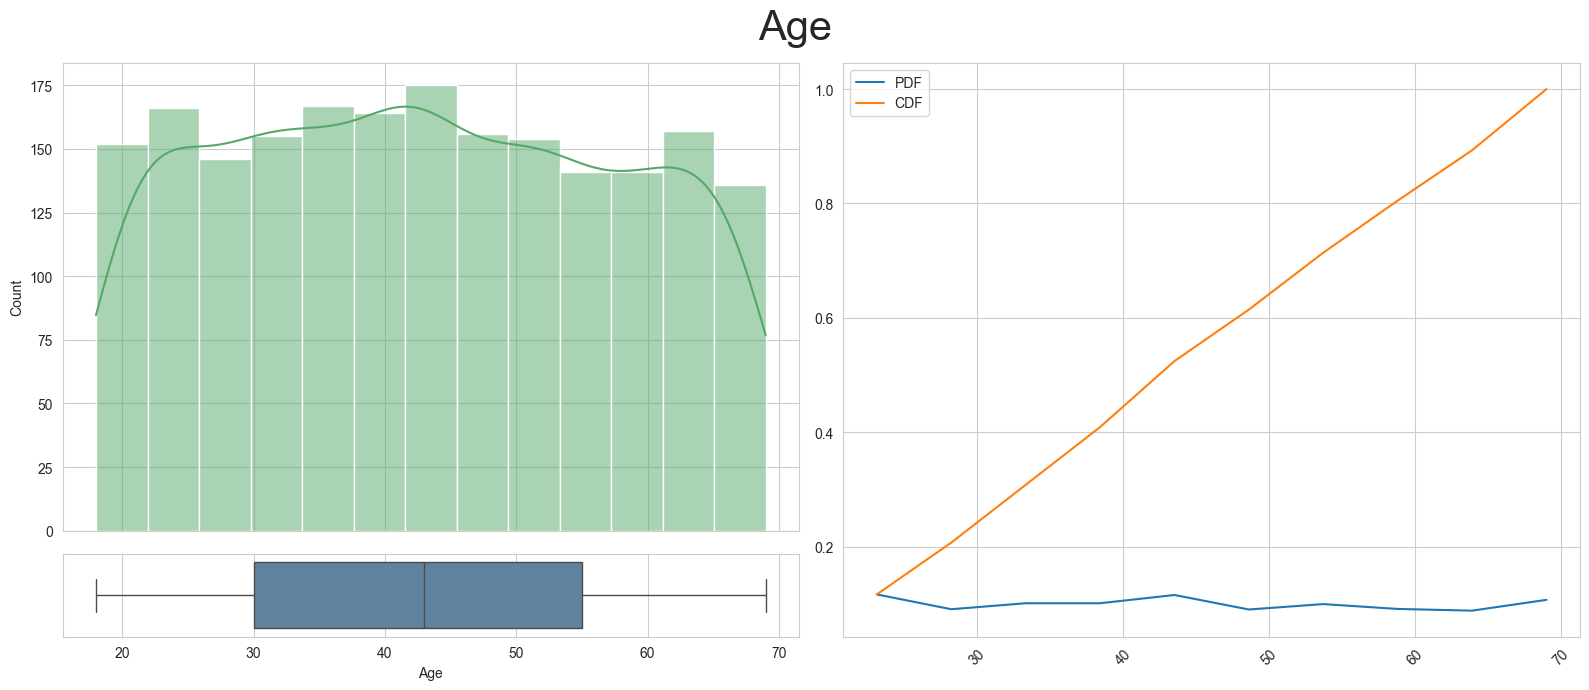

================== Age ==================
                             
count                  2010.0
mean                43.010448
std                 14.740003
min                      18.0
25%                      30.0
50%                      43.0
75%                      55.0
max                      69.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.04478
type     right(positive)-skew


================== Age_categorized ==================
         Group  Count      %
0        Adult    619  31.31
1  Middle-Aged    558  28.22
2        Young    473  23.93
3          Old    327  16.54
تعداد مقادیر گمشده در Age: 0

Gender


================== Gender ==================
    Group  Count      %
0  Female   1223  60.85
1    Male    787  39.15
تعداد مقادیر گمشده در Gender: 0
مقادیر یکتا در Gender: ['Female' 'Male']


================== Gender ==================
    Group  Count      %
0  Female   1223  60.85
1    Male    787  39.15

Income
تعداد مقادیر گمشده در Income: 0


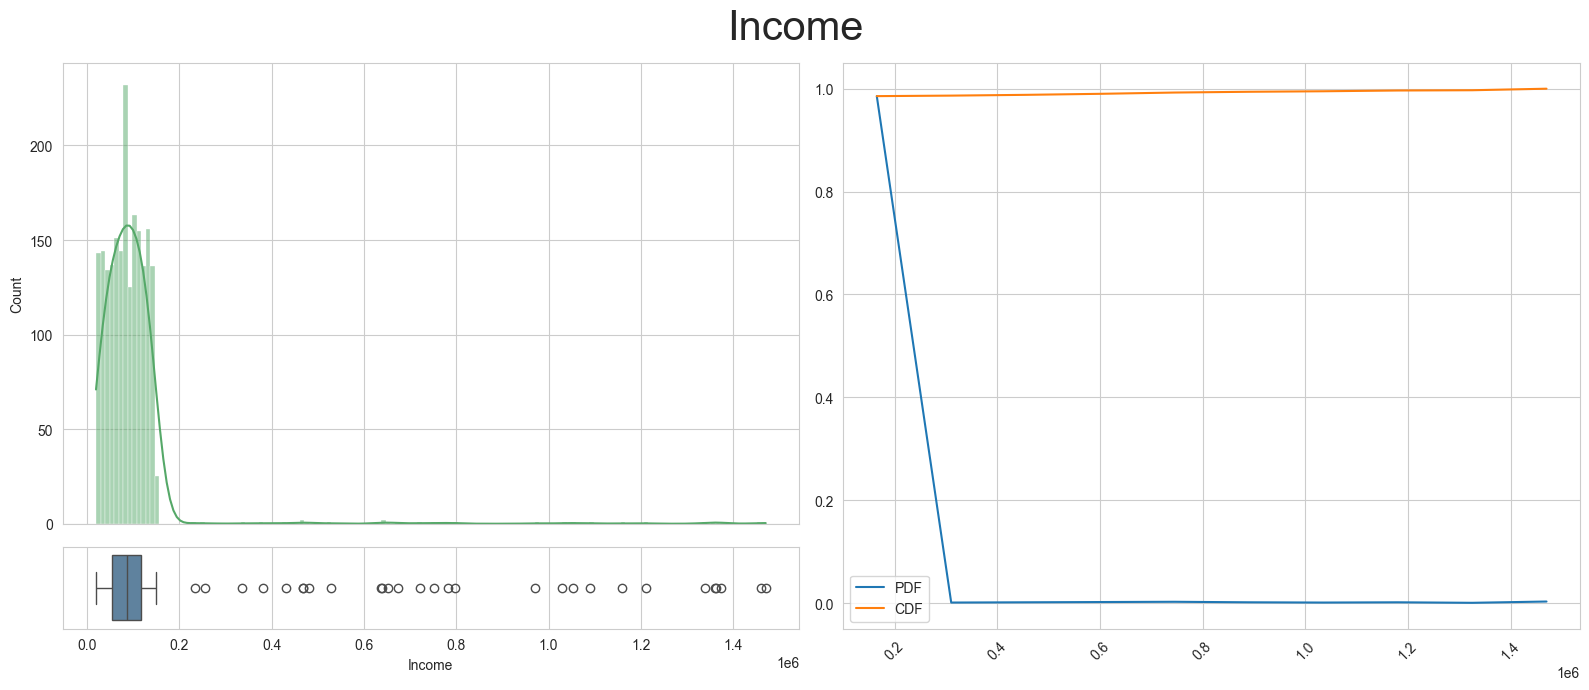

================== Income ==================
                             
count                  2010.0
mean             95933.934328
std             106571.274572
min                   20014.0
25%                  55001.25
50%                   86481.0
75%                  117053.0
max                 1470150.0
shapiro               0.00000
normal                  False
missing                     0
skew                  8.73299
type     right(positive)-skew


================== Income_categorized ==================
       Group  Count      %
0     Medium    542  26.98
1  Very High    503  25.04
2        Low    502  24.99
3       High    462  23.00

LoyaltyPoints


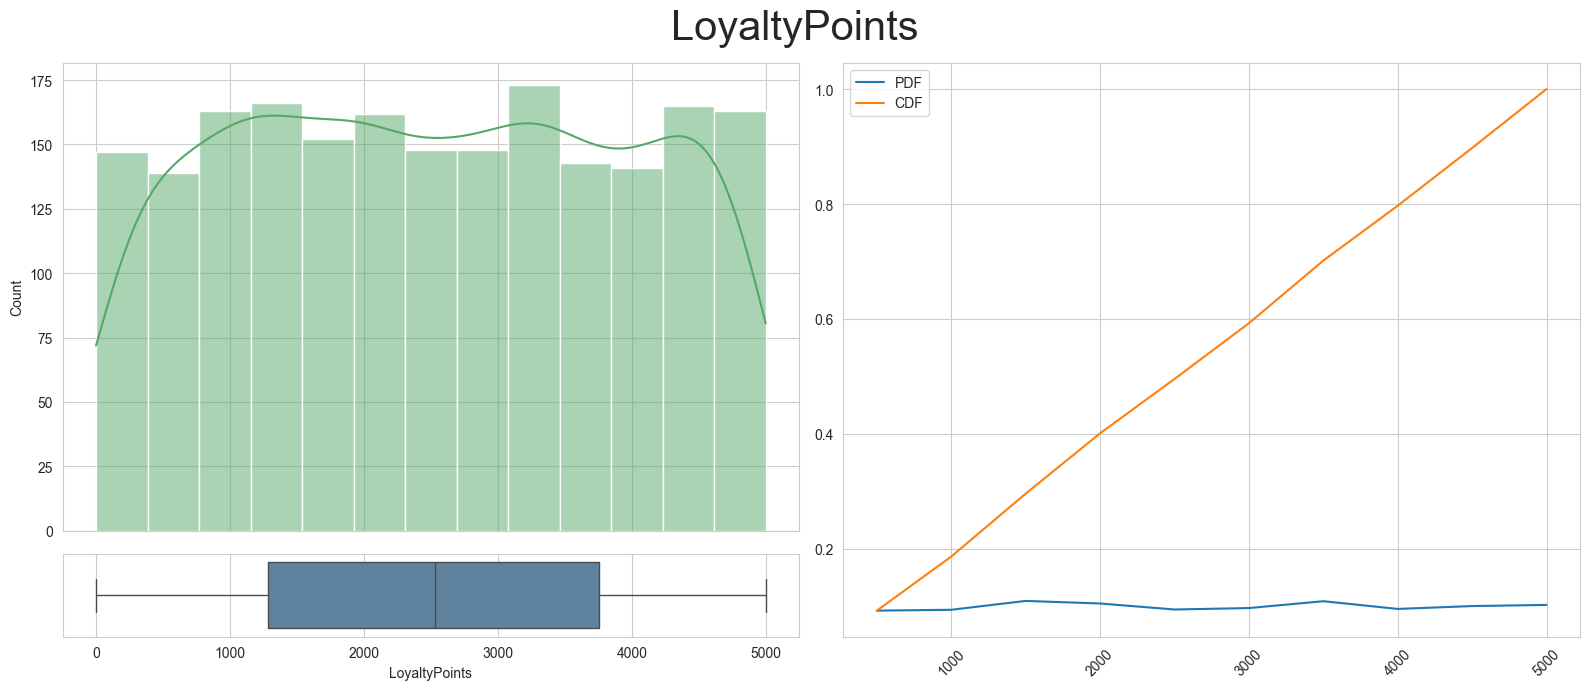

================== LoyaltyPoints ==================
                             
count                  2010.0
mean              2520.113433
std               1435.928358
min                       1.0
25%                    1287.0
50%                    2527.5
75%                    3752.0
max                    4999.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00677
type     right(positive)-skew
تعداد مقادیر گمشده در LoyaltyPoints: 0


================== LoyaltyPoints_categorized ==================
    Group  Count      %
0  Medium    670  33.35
1    High    670  33.35
2     Low    669  33.30


In [13]:
# 1. Age (عددی)
print("\nAge")
describe_numerical_col(df, 'Age')

bins = [18, 30, 45, 60, 70]
bin_labels = ['Young', 'Adult', 'Middle-Aged', 'Old']
categorize_numerical_col('Age', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'Age_categorized')
# بررسی مقادیر گمشده
print(f"تعداد مقادیر گمشده در Age: {df['Age'].isna().sum()}")
# اگر گمشده وجود داشت، با میانه پر می‌کنیم
if df['Age'].isna().sum() > 0:
    df['Age'].fillna(df['Age'].median(), inplace=True)
    print("مقادیر گمشده در Age با میانه پر شدند.")

# 2. Gender (کیفی)
print("\nGender")
describe_categorical_col(df, 'Gender')
# بررسی مقادیر گمشده
print(f"تعداد مقادیر گمشده در Gender: {df['Gender'].isna().sum()}")
# اگر گمشده وجود داشت، با mode پر می‌کنیم
if df['Gender'].isna().sum() > 0:
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    print("مقادیر گمشده در Gender با mode پر شدند.")
# بررسی مقادیر غیرمنتظره (مثلاً typo)
print("مقادیر یکتا در Gender:", df['Gender'].unique())
# اگر مقادیر غیرمنتظره (مثل 'male' و 'Male') وجود داشت، اصلاح کنیم
df['Gender'] = df['Gender'].str.capitalize()
describe_categorical_col(df, 'Gender')

# 3. Income (عددی)
print("\nIncome")
# بررسی مقادیر گمشده
print(f"تعداد مقادیر گمشده در Income: {df['Income'].isna().sum()}")
# پر کردن مقادیر گمشده با میانه (به دلیل skew)
if df['Income'].isna().sum() > 0:
    df['Income'].fillna(df['Income'].median(), inplace=True)
    print("مقادیر گمشده در Income با میانه پر شدند.")
describe_numerical_col(df, 'Income')
# دسته‌بندی درآمدی
bins = pd.qcut(df['Income'], q=4, duplicates='drop', retbins=True)[1]
bin_labels = ['Low', 'Medium', 'High', 'Very High']
categorize_numerical_col('Income', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'Income_categorized')

# 4. LoyaltyPoints (عددی)
print("\nLoyaltyPoints")
describe_numerical_col(df, 'LoyaltyPoints')
# بررسی مقادیر گمشده
print(f"تعداد مقادیر گمشده در LoyaltyPoints: {df['LoyaltyPoints'].isna().sum()}")
# اگر گمشده وجود داشت، با میانه پر می‌کنیم
if df['LoyaltyPoints'].isna().sum() > 0:
    df['LoyaltyPoints'].fillna(df['LoyaltyPoints'].median(), inplace=True)
    print("مقادیر گمشده در LoyaltyPoints با میانه پر شدند.")
# دسته‌بندی نقاط وفاداری
bins = pd.qcut(df['LoyaltyPoints'], q=3, duplicates='drop', retbins=True)[1]
bin_labels = ['Low', 'Medium', 'High']
categorize_numerical_col('LoyaltyPoints', bins=bins, bins_name=bin_labels)
describe_categorical_col(df, 'LoyaltyPoints_categorized')

تحلیل دو متغیره


1. Age vs Conversion


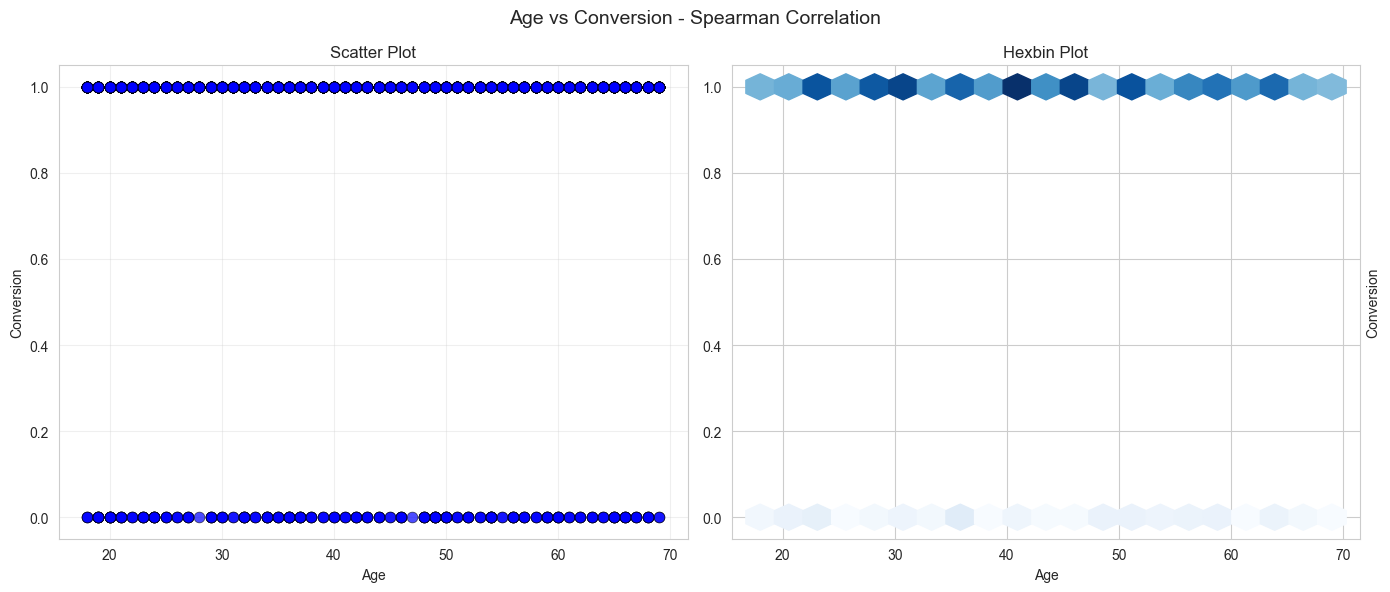

=============== Age vs Conversion ===============
                                
shapiro_p_col1           0.00000
shapiro_p_col2           0.00000
col1_normal                False
col2_normal                False
test_used               Spearman
correlation              0.00203
r_squared                0.00000
p_value                  0.92753
significant                False
relationship_strength       weak
relationship_direction  positive
{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 219266.5,
   "p-value": 0.9275457449394919,
   "decision": "Failed"
}

2. Gender vs Conversion


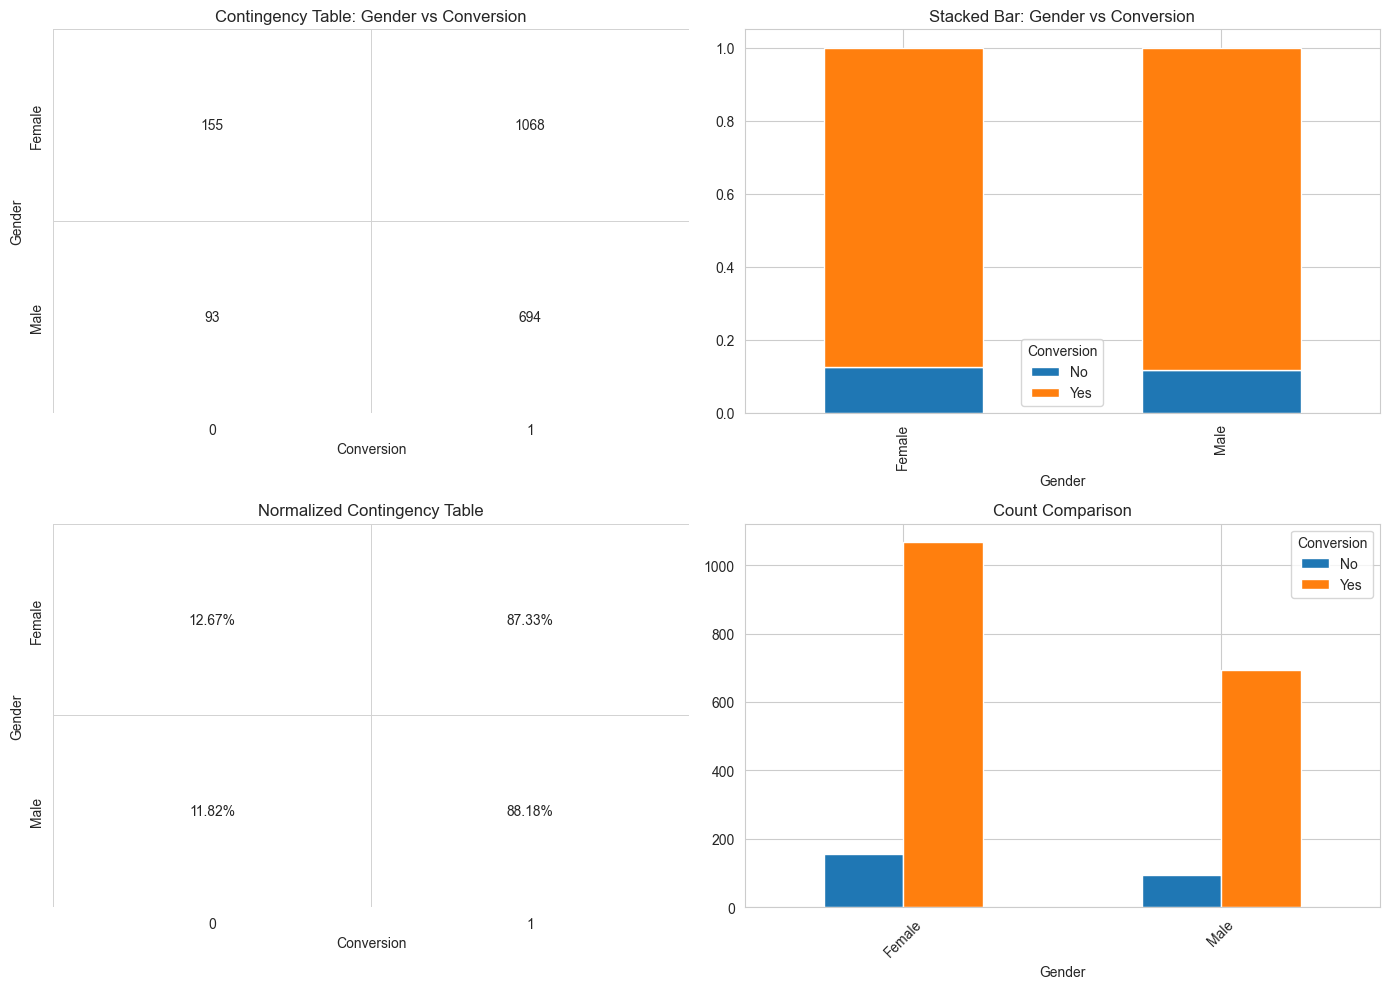

{
   "categories vs target": "vs-target",
   "chi2_stat": 0.2505730608417282,
   "p_value": 0.616671856477215,
   "degrees_of_freedom": 1,
   "contingency_table": {
      "0": {
         "Female": 155,
         "Male": 93
      },
      "1": {
         "Female": 1068,
         "Male": 694
      }
   }
}

3. Income vs Conversion


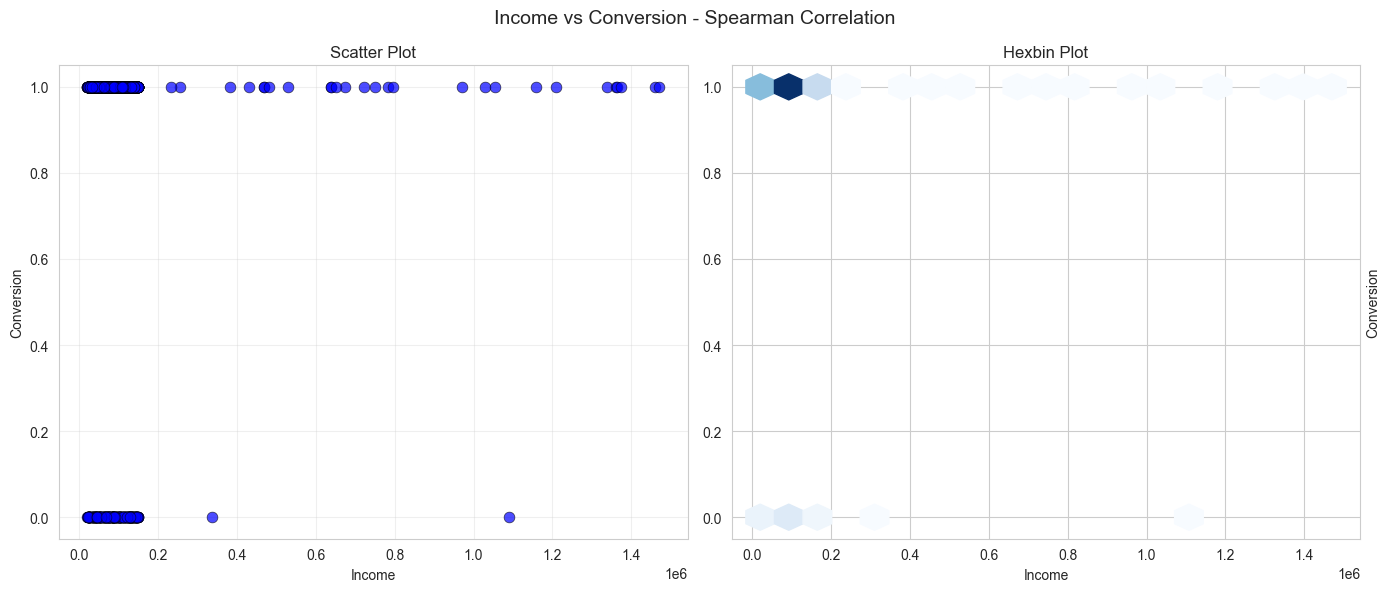

=============== Income vs Conversion ===============
                                
shapiro_p_col1           0.00000
shapiro_p_col2           0.00000
col1_normal                False
col2_normal                False
test_used               Spearman
correlation              0.00426
r_squared                0.00002
p_value                  0.84876
significant                False
relationship_strength       weak
relationship_direction  positive
{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 220120.5,
   "p-value": 0.8487472386793408,
   "decision": "Failed"
}

4. LoyaltyPoints vs Conversion


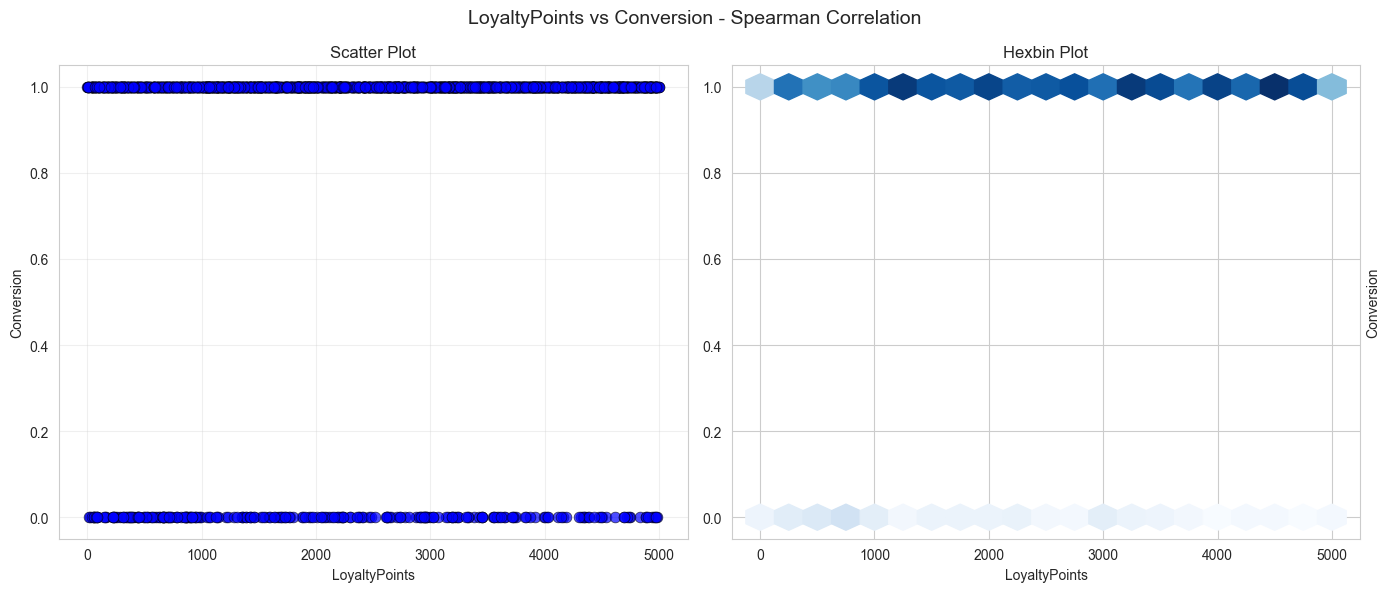

=============== LoyaltyPoints vs Conversion ===============
                                
shapiro_p_col1           0.00000
shapiro_p_col2           0.00000
col1_normal                False
col2_normal                False
test_used               Spearman
correlation              0.11451
r_squared                0.01311
p_value                  0.00000
significant                 True
relationship_strength       weak
relationship_direction  positive
{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 262410.5,
   "p-value": 2.8575677741915065e-07,
   "decision": "Rejected"
}


In [11]:
print("\n1. Age vs Conversion")
describe_target_relationship(df, 'Age', 'Conversion')
# تست آماری
data_group1 = df[df['Conversion'] == 1]['Age'].values
data_group2 = df[df['Conversion'] == 0]['Age'].values
if len(data_group2) > 0:  # اگر داده برای Conversion=0 وجود داشت
    numeric_nonparm_test("two-independent", data_group1, data_group2)
else:
    print("تحلیل Age vs Conversion ممکن نیست چون همه Conversion=1 هستند.")

print("\n2. Gender vs Conversion")
describe_cat_cat_relationship(df, 'Gender', 'Conversion')
categorical_tests('vs-target', df, 'Gender', 'Conversion')


print("\n3. Income vs Conversion")
describe_target_relationship(df, 'Income', 'Conversion')
# تست آماری
data_group1 = df[df['Conversion'] == 1]['Income'].values
data_group2 = df[df['Conversion'] == 0]['Income'].values
if len(data_group2) > 0:
    numeric_nonparm_test("two-independent", data_group1, data_group2)
else:
    print("تحلیل Income vs Conversion ممکن نیست چون همه Conversion=1 هستند.")


print("\n4. LoyaltyPoints vs Conversion")
describe_target_relationship(df, 'LoyaltyPoints', 'Conversion')
# تست آماری
data_group1 = df[df['Conversion'] == 1]['LoyaltyPoints'].values
data_group2 = df[df['Conversion'] == 0]['LoyaltyPoints'].values
if len(data_group2) > 0:
    numeric_nonparm_test("two-independent", data_group1, data_group2)
else:
    print("تحلیل LoyaltyPoints vs Conversion ممکن نیست چون همه Conversion=1 هستند.")

# تحلیل‌های اضافی بین متغیرها


<h3>Age vs Income</h3>


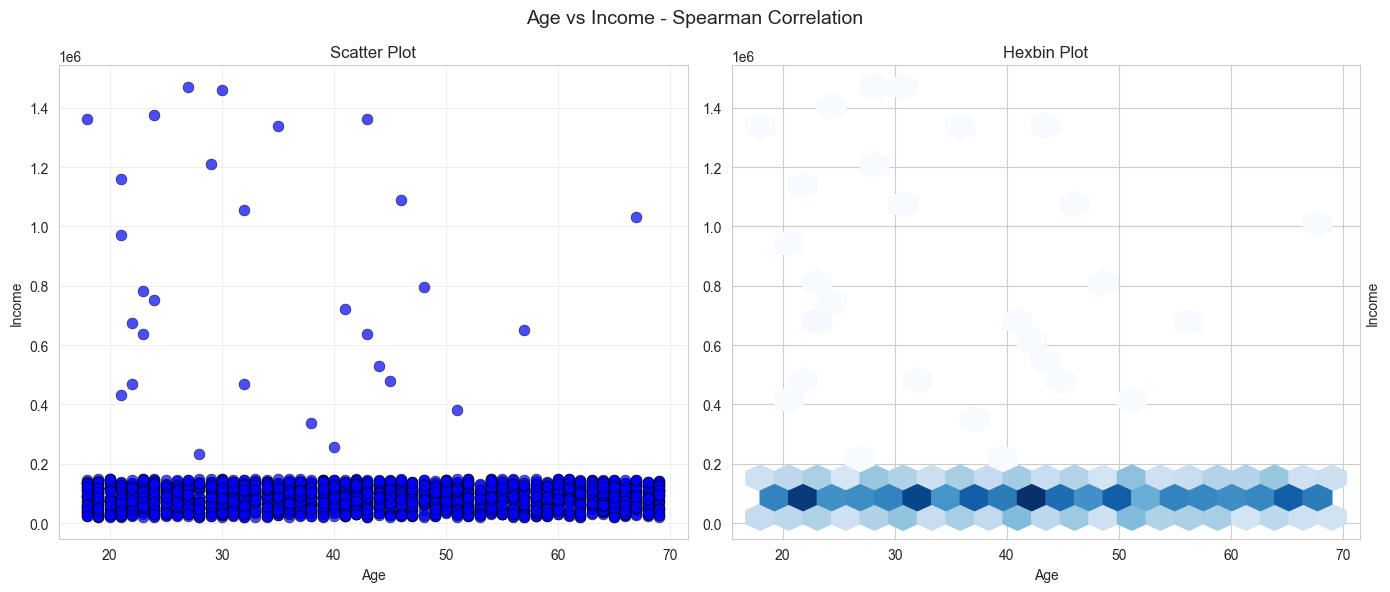

=============== Age vs Income ===============
                                
shapiro_p_col1           0.00000
shapiro_p_col2           0.00000
col1_normal                False
col2_normal                False
test_used               Spearman
correlation             -0.00467
r_squared                0.00002
p_value                  0.83429
significant                False
relationship_strength       weak
relationship_direction  negative

<h3>Gender vs Income</h3>


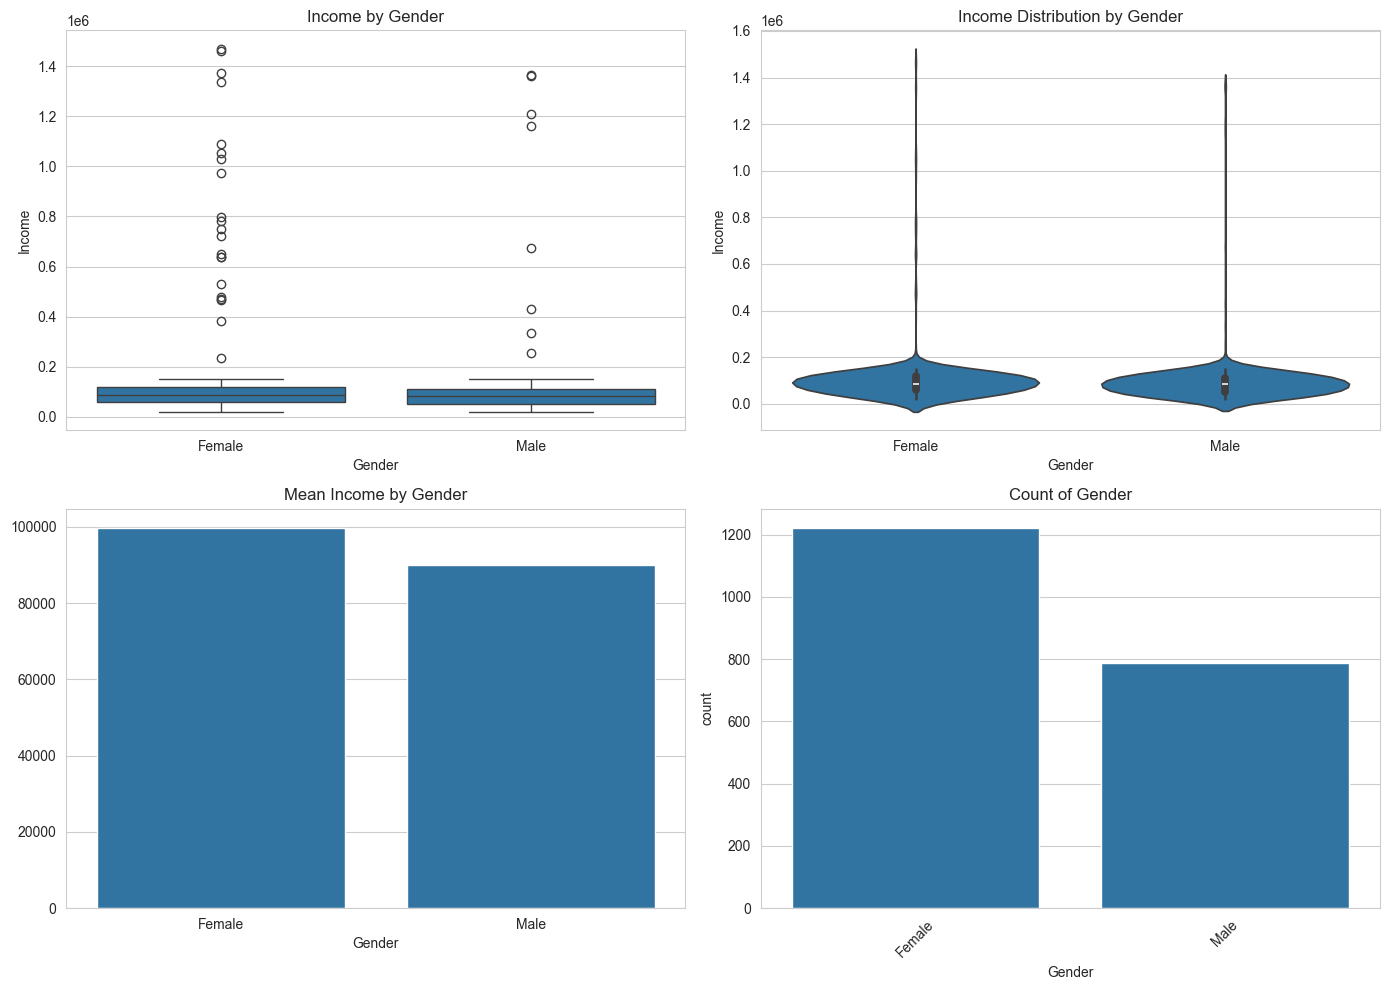


<h3>Gender vs LoyaltyPoints</h3>


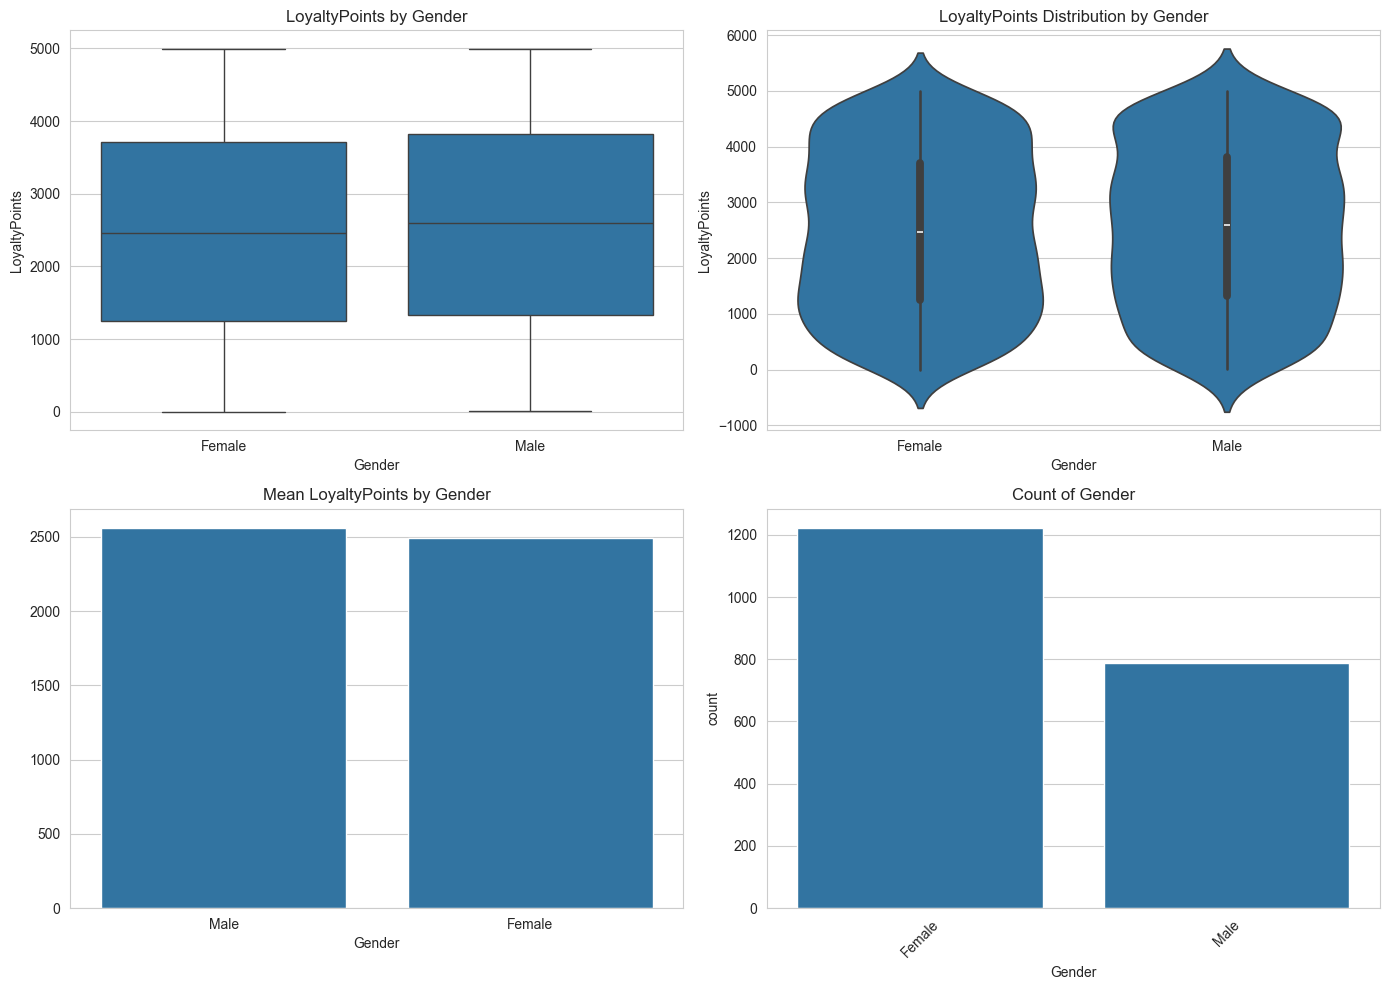

In [12]:
print("\n<h3>Age vs Income</h3>")
describe_num_num_relationship(df, 'Age', 'Income')

print("\n<h3>Gender vs Income</h3>")
describe_cat_num_relationship(df, 'Gender', 'Income')

print("\n<h3>Gender vs LoyaltyPoints</h3>")
describe_cat_num_relationship(df, 'Gender', 'LoyaltyPoints')